# Custom Dataset - Flowers with Transfer Learning (ResNet50)



<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flower.png" width="1000" align="center">


In [2]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flowers.zip
!unzip -qq flowers.zip

--2024-02-01 17:56:14--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/flowers.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.154, 52.95.142.26, 3.5.246.13, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235742212 (225M) [application/octet-stream]
Saving to: ‘flowers.zip’

flowers.zip         100%[===================>] 224.82M  13.2MB/s    in 16s     

2024-02-01 17:56:30 (14.4 MB/s) - ‘flowers.zip’ saved [235742212/235742212]



### Resnet
https://keras.io/api/applications/resnet/

input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format)


## Transfer Learning

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/transfer.png" width="600" align="center">

### ResNet50 has input 224x224

In [4]:
dataset = 'flowers'
image_size = (224, 224)
batch_size = 32
ch=3

## With Augmentation -->ImageDataGenerator

**Preprocess Input as the Pre-trained model request!**

The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

So any other way to achieve this in the data pipeline or as part of the model would also be acceptable.

In [7]:
import tensorflow.keras.applications.resnet50

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
datagenerator  = ImageDataGenerator(
                                    preprocessing_function=preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.2 #prepare also for validtion dataset!!!!!!!!
                                    )

training_set = datagenerator.flow_from_directory(dataset,
                                                subset="training",
                                                seed=667,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode = 'categorical',
                                                shuffle=False
                                                 )

validation_set = datagenerator.flow_from_directory(dataset,
                                                    subset="validation",
                                                    seed=667,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle=False
                                                    )

Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.


## Without Augmentation (image_dataset_from_directory)


In [ ]:
# ## No Augmentation (image_dataset_from_directory)
# training_set = image_dataset_from_directory(dataset,
#                                             validation_split=0.2,
#                                             subset="training",
#                                             seed=667,
#                                             image_size=image_size,
#                                             batch_size=batch_size,
#                                             label_mode = 'categorical',
#                                             shuffle = False
#                                             )

# validation_set = image_dataset_from_directory(dataset,
#                                               validation_split=0.2,
#                                               subset="validation",
#                                               seed=667,
#                                               image_size=image_size,
#                                               batch_size=batch_size,
#                                               label_mode = 'categorical',
#                                               shuffle = False
#                                               )
#class_names = training_set.class_names

In [10]:
training_set

In [11]:
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [12]:
num_classes = len(class_names)
num_classes

5

In [13]:
model = Sequential()

pretrained_model = ResNet50(include_top=False,
                            input_shape=(image_size[0],image_size[1],ch),
                            pooling='avg',
                            classes=num_classes,
                            weights='imagenet'
                            )

for layer in pretrained_model.layers:
    layer.trainable = False


model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


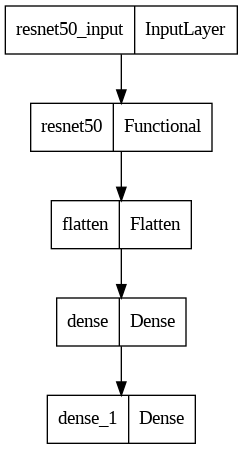

In [14]:
plot_model(model)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy']
              )

In [16]:
file_path="weights_best.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=10,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(validation_set),
                    callbacks=callbacks_list
                    )

Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.6037
Epoch 1: val_accuracy improved from -inf to 0.83508, saving model to weights_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 70s 569ms/step - loss: 1.5190 - accuracy: 0.6037 - val_loss: 0.4389 - val_accuracy: 0.8351
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.8030
Epoch 2: val_accuracy did not improve from 0.83508
109/109 [==============================] - 59s 546ms/step - loss: 0.5174 - accuracy: 0.8030 - val_loss: 0.4429 - val_accuracy: 0.8281
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8536
Epoch 3: val_accuracy improved from 0.83508 to 0.84088, saving model to weights_best.h5
109/109 [==============================] - 59s 545ms/step - loss: 0.4027 - accuracy: 0.8536 - val_loss: 0.4076 - val_accuracy: 0.8409
Epoch 4/10
109/109 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8732
Epoch 4: val_accuracy improved from 0.84088 to 0.88153, saving model to weights_best.h5
109/109 [==============================] - 64s 588ms/step - loss: 0.3426 - accuracy

In [17]:
model.save('ResNet50_flowers.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


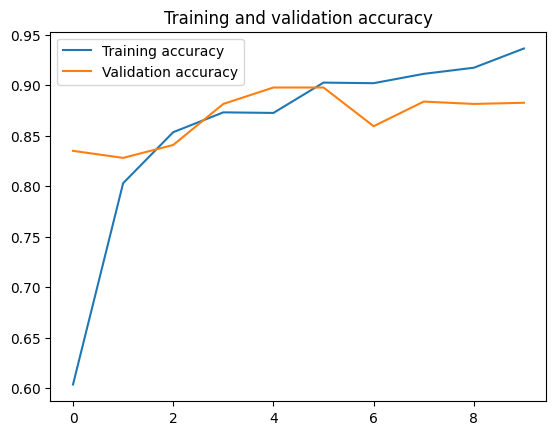

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

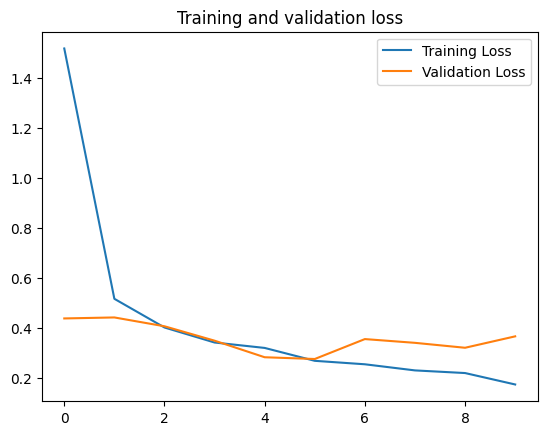

In [19]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [20]:
model = load_model('ResNet50_flowers.h5')

In [21]:
res =[]
for i in range(0,27):
    #print(np.argmax(validation_set[i][1],axis=1))
    res.append(np.argmax(validation_set[i][1],axis=1))

y_test = []
for sublist in res:
    y_test.extend(sublist)
y_test = np.array(y_test)
#y_test

In [22]:
predict_x = model.predict(validation_set)
y_pred = np.argmax(predict_x,axis=1)
y_pred

27/27 [==============================] - 13s 440ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 4, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
from sklearn.metrics import classification_report
import seaborn as sns

print(classification_report(y_pred, y_test, target_names=class_names))

              precision    recall  f1-score   support

       daisy       0.86      0.97      0.91       136
   dandelion       0.97      0.88      0.92       231
        rose       0.77      0.97      0.86       124
   sunflower       0.96      0.80      0.87       175
       tulip       0.90      0.91      0.91       195

    accuracy                           0.90       861
   macro avg       0.89      0.90      0.89       861
weighted avg       0.91      0.90      0.90       861



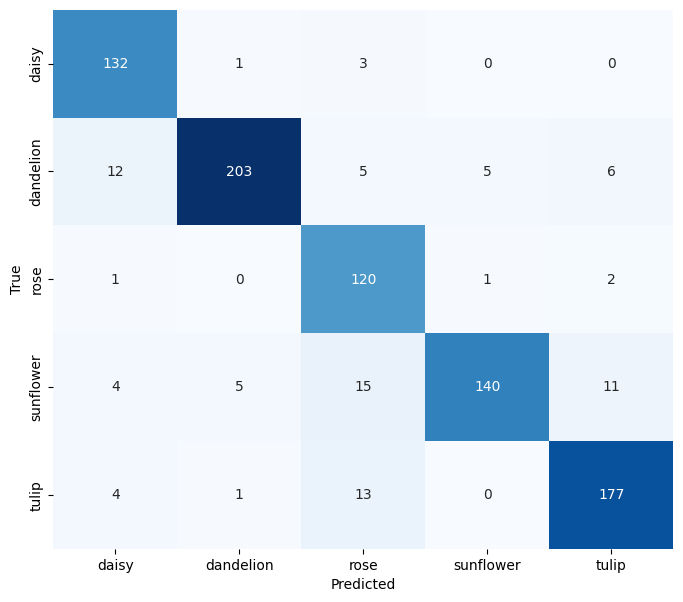

In [25]:
cm = pd.crosstab(y_pred,y_test,
                 rownames = ['True'],
                 colnames = ['Predicted'],
                 )

plt.figure(figsize=(8,7))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g',xticklabels=class_names, yticklabels=class_names,cbar=False);

In [ ]:
# Download test images

In [26]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/test_images.zip
!unzip --qq test_images.zip

--2024-02-01 18:22:30--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/test_images.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.178, 52.95.150.98, 52.95.148.182, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280728 (274K) [application/octet-stream]
Saving to: ‘test_images.zip’

test_images.zip     100%[===================>] 274.15K   526KB/s    in 0.5s    

2024-02-01 18:22:32 (526 KB/s) - ‘test_images.zip’ saved [280728/280728]



In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
#     # predicting images
#     path = '/content/' + fn
#     img = image.load_img(path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     images = np.vstack([x])
#     pred = model.predict(images, batch_size=10)
#     print(pred)
#     finale = np.argmax(pred, axis=-1)
#     print(finale)

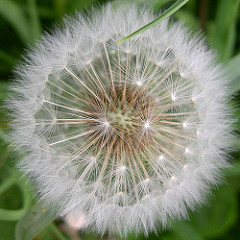

test_images/dandelion.jpg


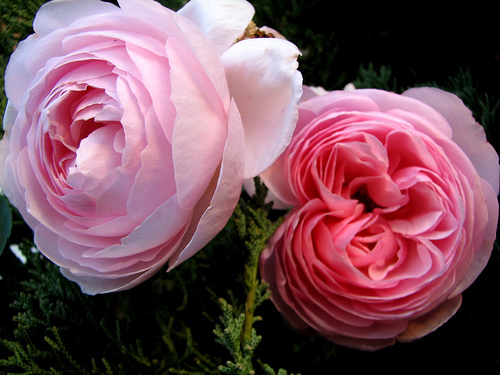

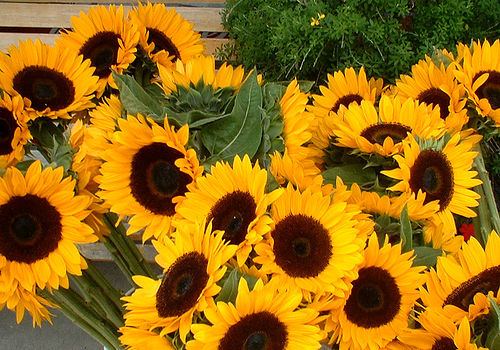

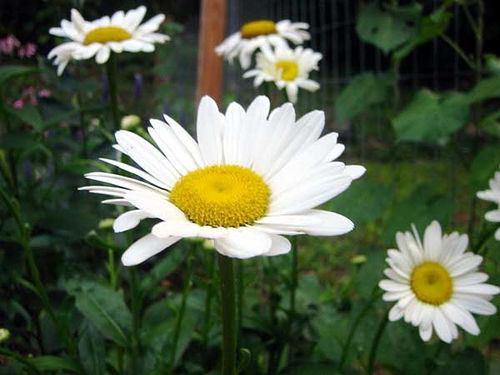

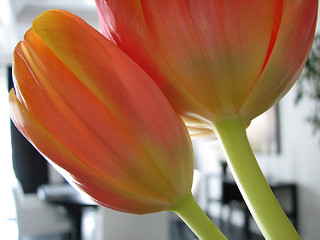

test_images/rose.jpg
test_images/sunflower.jpg
test_images/daisy.jpg
test_images/tulip.jpg


In [27]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('test_images/*.jpg'): #estensione file
    display(Image(filename=imageName))
    print(imageName)

### Class names

In [29]:
import os
lista = os.listdir('test_images/') #['rose.jpg', 'sunflower.jpg', 'dandelion.jpg', 'tulip.jpg', 'daisy.jpg']

## train_generator.class_indices
# {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
classes = {0:"daisy",
           1:"dandelion",
           2:"rose",
           3:"sunflower",
           4:"tulip",
           }

finale=[]
name = []
res = []
for i in lista:
    path = '/content/test_images/' + i
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    pred = model.predict(images, batch_size=10)
    print(pred)
    result = np.argmax(pred, axis=-1)[0]
    print(result)
    name.append(i)
    finale.append(result)
    res.append(classes[result])

finale
print(name)
print(res)

1/1 [==============================] - 0s 21ms/step
[[6.6283695e-07 9.9999928e-01 8.6728064e-10 1.1424465e-08 4.2711179e-10]]
1
1/1 [==============================] - 0s 23ms/step
[[6.3140797e-05 2.0853242e-05 9.9173707e-01 7.8603257e-08 8.1789326e-03]]
2
1/1 [==============================] - 0s 22ms/step
[[7.8761297e-01 6.1940453e-03 2.3510827e-05 2.0609380e-01 7.5669479e-05]]
0
1/1 [==============================] - 0s 23ms/step
[[9.99989271e-01 1.06304587e-05 1.01620067e-10 1.67117818e-07
  2.53930010e-09]]
0
1/1 [==============================] - 0s 23ms/step
[[6.7594149e-03 1.7308895e-02 1.2734912e-04 7.5265583e-05 9.7572905e-01]]
4
['dandelion.jpg', 'rose.jpg', 'sunflower.jpg', 'daisy.jpg', 'tulip.jpg']
['dandelion', 'rose', 'daisy', 'daisy', 'tulip']


## Transform Keras model to TFlite

In [30]:
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open('model.tflite', "wb").write(tfmodel)

98173128

## Transform Keras model to Tensorflow Protopbuf .pb

In [31]:
import tensorflow as tf
import os

model = tf.keras.models.load_model("ResNet50_flowers.h5")
model.save(os.path.join("model", model.name))

## Convert to ONNX using the Python API

In [ ]:
#model must have been saved on .pb format
#model.save(os.path.join("model", model.name))

In [32]:
!pip install tf2onnx --quiet
!pip install onnxruntime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00


In [33]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "ResNet50_flowers.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]